In [1]:
import matplotlib.pyplot as plt
import numpy as np
import phantom_generator as pg
from scipy.ndimage import gaussian_filter1d
from scipy import signal, stats

import seaborn as sns
sns.set(style="darkgrid", font_scale=1.4)

# Пайплайн на фантоме

## Подготовка данных

In [2]:
shape = (1000, 1000)

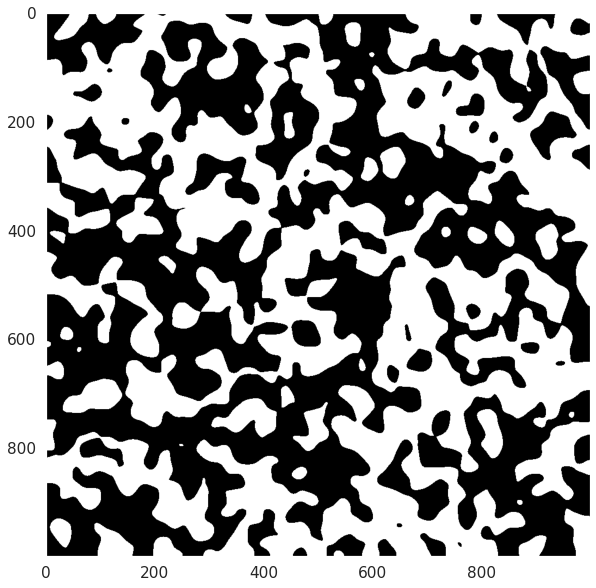

In [3]:
characteristical_pore_length = 12
porosity = 0.5
phantom = pg.gen_phantom(shape, porosity, characteristical_pore_length)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(phantom, cmap='gray')
ax.grid()

Возьмем какой-нибудь ряд и построим график его профиля ну и зашумим его , чтобы более менее было похоже на экспериментальный сигнал 

<class 'numpy.ndarray'>


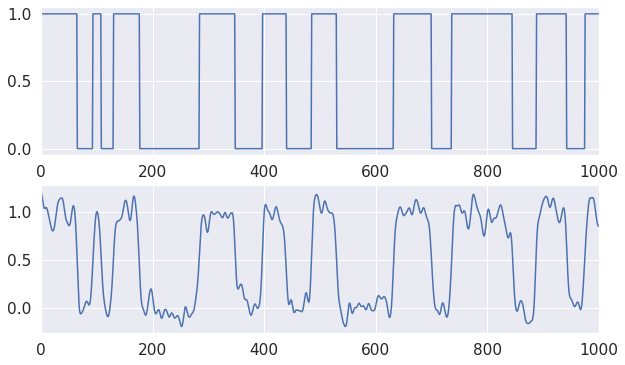

In [4]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,2*3))

sig_init = phantom[500].astype(float)
axes[0].plot(sig_init)

noise = np.random.normal(0,0.3,sig_init.size)
print(type(noise))
sig_init += noise
sig_init = gaussian_filter1d(sig_init, 3)

axes[1].plot(sig_init)

_ = [ax.set_xlim(0, sig_init.size) for ax in axes]


## Вейвлет разложение
Здесь мы зашумленный сигнал раскладываем повейвлет-функции, называемой mexican hat, которая выглядит так:

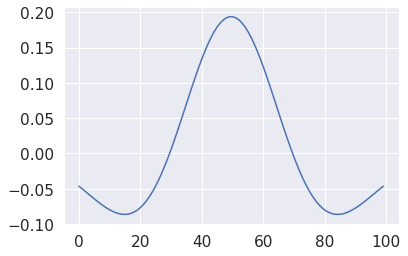

In [5]:
ricker = signal.ricker

def custom_haar(points, width):
    x_arr = np.arange(points)
    center = points // 2
    y1 = np.array([1 if center-width < x <= center else 0 for x in x_arr ])
    y2 = np.array([-1 if center < x <= center+width else 0 for x in x_arr ])
    return y1+y2

def custom_rectangular(points, width):
    x_arr = np.arange(points)
    center = points // 2
    return np.array([1 if center-width//2 <= x <= center+width//2 else 0 for x in x_arr ])


wavelet_func = ricker
plt.plot(wavelet_func(100, 20))

То есть при разложении для каждой точки нашего зашумленного сегнала, будет сопоставлен данный вейвлет с определенным значением ширины функции, умноженный на определенный коэффициент (амплитуду). Так, для каждой есть 2 параметра: амплитуда и ширина.

Так как мы ищем ширину именно для пор, а функция у нас имеет вид "горки", а не "ямки", то логично, если все поры бы точже стали "горками". Т.е. давайте инвертируем сигнал, чтобы поры имели значения близкие к 1, а материал - 0.

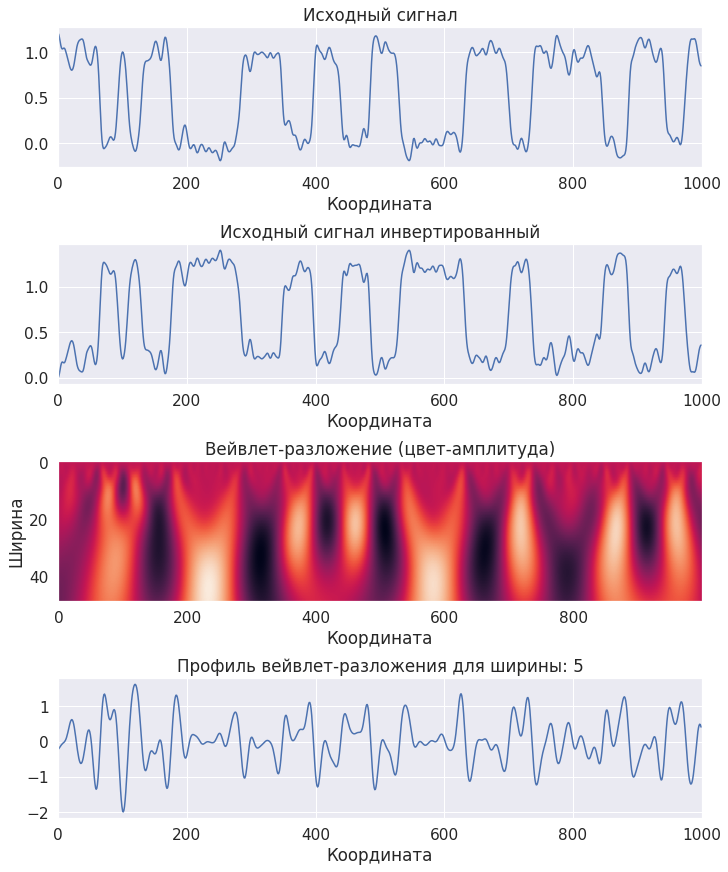

In [32]:

fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(10,3*4), constrained_layout=True)

axes[0].plot(sig_init)
axes[0].set_xlim(0, sig_init.size)
axes[0].set_title("Исходный сигнал")
axes[0].set_xlabel("Координата")

sig = sig_init.max() - sig_init
axes[1].plot(sig)
axes[1].set_xlim(0, sig.size)
axes[1].set_title("Исходный сигнал инвертированный")
axes[1].set_xlabel("Координата")

widths = np.arange(1, 50)
cwtmatr = signal.cwt(sig, wavelet_func, widths)
axes[2].imshow(cwtmatr, aspect='auto')
axes[2].set_title("Вейвлет-разложение (цвет-амплитуда)")
axes[2].set_ylabel("Ширина")
axes[2].set_xlabel("Координата")
axes[2].grid()

w = 5
axes[3].plot(cwtmatr[w])
axes[3].set_xlim(0, sig.size)
axes[3].set_title(f"Профиль вейвлет-разложения для ширины: {w}")
axes[3].set_xlabel("Координата")
None

Теперь найдем наилучшую ширину разложения. Возьмем для этого разложения определенной ширины и сравним корреляцию Пирсона с сигналом, который разлагали. Где Пирсон будет максимальным -- там и наилучшее разложение. Эту ширину и считаем за среднюю, так как она, получается, встречается чаще всех т.к. дает лучшее разложение.

Text(0.5, 0, 'Координата')

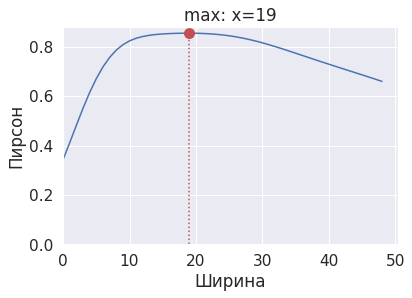

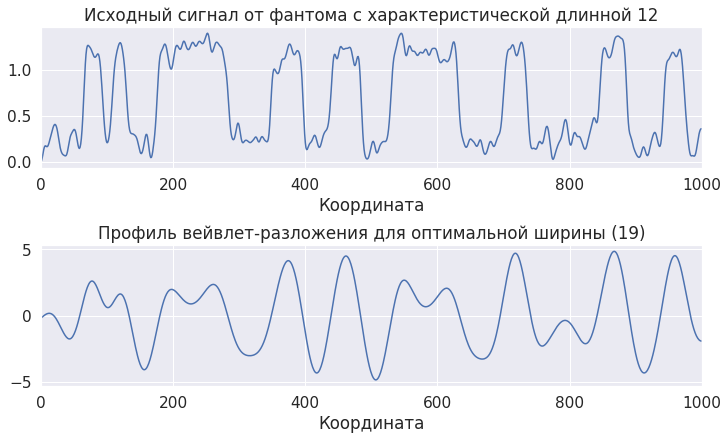

In [7]:
fig, ax = plt.subplots(figsize=(6,4))

pearsons = [stats.pearsonr(row, sig)[0] for row in cwtmatr]
ax.plot(pearsons)
ax.plot([np.argmax(pearsons)], np.max(pearsons), '-o', c='r', markersize=10)
ax.axvline(np.argmax(pearsons), linestyle="dotted", color='r')
ax.set_title(f"max: x={np.argmax(pearsons)}")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_xlabel("Ширина")
ax.set_ylabel("Пирсон")

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,3*2), constrained_layout=True)

axes[0].plot(sig)
axes[0].set_xlim(0, sig.size)
axes[0].set_title(f"Исходный сигнал от фантома с характеристической длинной {characteristical_pore_length}")
axes[0].set_xlabel("Координата")

axes[1].plot(cwtmatr[np.argmax(pearsons)])
axes[1].set_xlim(0, sig.size)
axes[1].set_title(f"Профиль вейвлет-разложения для оптимальной ширины ({np.argmax(pearsons)})")
axes[1].set_xlabel("Координата")

как видно, разложение более-менее удачное. Надо проанализировать зависимость ширины вейвлета и ширины фантома

----

# Анализ зависимости многих между шириной вейвлета и шириной фантома

19.0

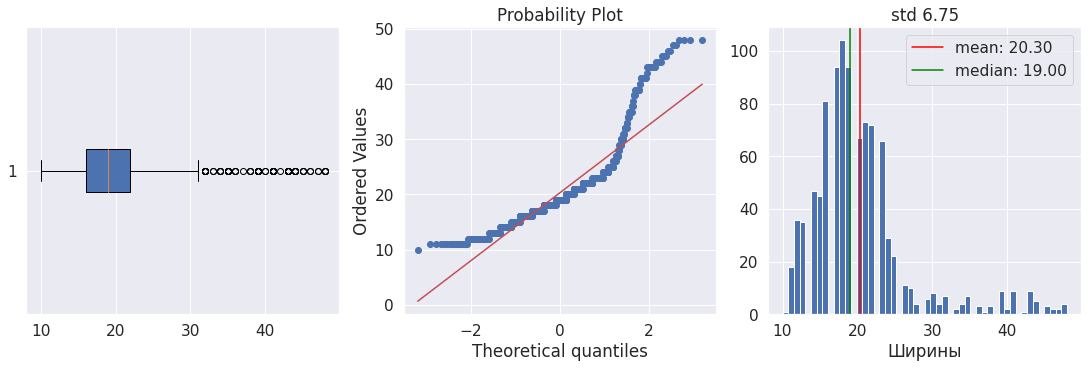

In [8]:
def noise_signal(sig):
    sig = sig.astype(float)
    noise = np.random.normal(0,0.3,sig.size)
    sig += noise
    sig = gaussian_filter1d(sig, 3)
    
    return sig


def invert_signal(sig):
    return sig.max() - sig


def get_width_of_a_row(sig, wavelet_func):
    widths = np.arange(1, 50)
    cwtmatr = signal.cwt(sig, wavelet_func, widths)
    pearsons = [stats.pearsonr(row, sig)[0] for row in cwtmatr]

    return np.argmax(pearsons)


def get_width_phantom(phantom, wavelet_func, plot_stat=True):
    """
    прохожу по всем рядам и возвращаю медиану
    """

    widths = []

    # все ряды по горизонтали
    for row in phantom:
        w = get_width_of_a_row(noise_signal(row), wavelet_func)
        widths.append(w)

    # все ряды по вертикали если есть анизатропия (закоментил для ускорения рассчетов)
    # for row in phantom.T:
    #     w = get_width_of_a_row(noise_signal(row), wavelet_func)
    #     widths.append(w)
    
    if plot_stat:
        fig, axes = plt.subplots(ncols=3, figsize=(15,5), constrained_layout=True)
        axes[0].boxplot(widths, patch_artist=True, vert=False)
        
        stats.probplot(widths, dist="norm", plot=axes[1])
        axes[2].set_title(f"Q-Q plot")
        
        axes[2].hist(widths, bins=50)
        axes[2].set_title(f"std {np.std(widths):.2f}")
        axes[2].axvline(np.mean(widths), color='red', label=f"mean: {np.mean(widths):.2f}")
        axes[2].axvline(np.median(widths), color='green', label=f"median: {np.median(widths):.2f}")
        axes[2].set_xlabel("Ширины")
        axes[2].legend()

    return np.median(widths)


get_width_phantom(phantom, ricker)

Видно, что распределение не совсем нормальное с выбросами, поэтому для характеристики лучше использовать медиану а не среднее.

Попробуем теперь для разных характеристических длин (ХД) и пористостей построить графики зависимости медианы распределений вейвлет-ширин. Для статистики, будем для каждой пары {пористость, ХД} генерить по 5 фантомов и для каждого фантома находить 5 медиан ширин, затем их усреднять и находить std.

**ВЕЙВЛЕТ-ШИРИНОЙ ФАНТОМА БУДЕМ НАЗЫВАТЬ МЕДИАНУ ЕГО РАСПРЕДЕЛЕНИЯ**

In [20]:
R2 = lambda x1, x2: stats.pearsonr(x1, x2)[0] ** 2

characteristical_pore_lengths = [5, 7, 10, 13, 15, 17, 20]
porosity = 0.5

phantom_shape = [500, 500] #для быстрых рассчетов
attempts = 5

def plot_width_po_length_dependance(porosity,
                                    characteristical_pore_lengths,
                                    phantom_shape=phantom_shape,
                                    attempts=attempts):

    fig, ax = plt.subplots(figsize=(5, 5))

    mean_phantom_width, std_phantom_width = [], [] # mean и std вейвлет ширин фантома

    for cpl in characteristical_pore_lengths:
        mean_phantom_width_for_a_cpe, std_phantom_width_for_a_cpe = [], [] 
        for _ in range(attempts):
            phantom = pg.gen_phantom(phantom_shape, porosity, cpl)
            widths = get_width_phantom(phantom, wavelet_func=ricker, plot_stat=False)
            mean_phantom_width_for_a_cpe.append(np.mean(widths))
            std_phantom_width_for_a_cpe.append(np.std(widths))
        mean_phantom_width.append(np.mean(mean_phantom_width_for_a_cpe))
        std_phantom_width.append(np.mean(std_phantom_width_for_a_cpe))


    ax.errorbar(characteristical_pore_lengths, mean_phantom_width, yerr=std_phantom_width, capsize=10)
    ax.set_title(f"Пористость: {porosity}; R^2: {R2(characteristical_pore_lengths, mean_phantom_width):.2f}")
    ax.set_xlabel("Характеристическая длина \n пор фантома")
    ax.set_ylabel("Оптимальная вейвлет-ширина")

    plt.show()


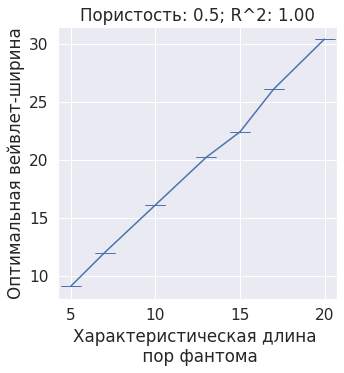

In [21]:
plot_width_po_length_dependance(porosity=0.5, characteristical_pore_lengths=characteristical_pore_lengths)

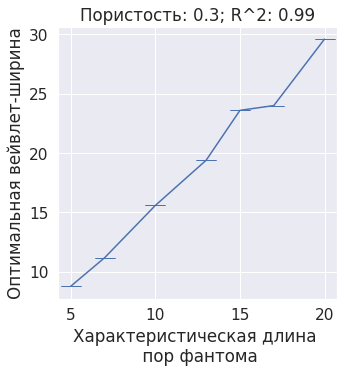

In [22]:
plot_width_po_length_dependance(porosity=0.3, characteristical_pore_lengths=characteristical_pore_lengths)

Пористости 0.3-0.5 это пористости, которые встречаются у сермет мембран. Как видно, для них коэффициент детерменации близок к единице, что говорит о ярко выраженной линейной зависимости. Более того, заввисимости инвариантны относительно пористостей.

Еще обратите внимание на черточки. Это error бары и они по оси y, просто слились в одну точку. Это говорит о устойчивости наших решений.

На глаз, можно аппроксимировать функции y=1.5*x

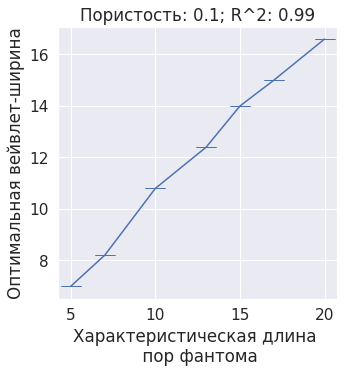

In [23]:
plot_width_po_length_dependance(porosity=0.1, characteristical_pore_lengths=characteristical_pore_lengths)

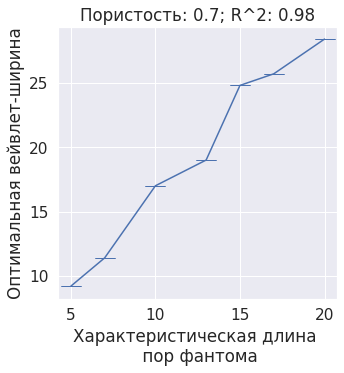

In [24]:
plot_width_po_length_dependance(porosity=0.7, characteristical_pore_lengths=characteristical_pore_lengths)

Пористость 0.1 встречается крайне редко. 0.7 я видел у полилактидов. Оба случая - экстремальные. Тем не менее, R^2 все равно близок к единице. Можно аппроксимировать линейно, однако здесь инвариантности по пористости уже нетб но у 0.7, прямая все равно близка к y=1.5*x.

При фильтрации это может будет не страшно, так как картинку пористоси 0.7 можно инвертнуть и сделать 0.3.

---------------

# Реальные данные

In [25]:
import h5py

h5f = h5py.File('sample.h5','r')

img2d = h5f['layer1'][:]
h5f.close()

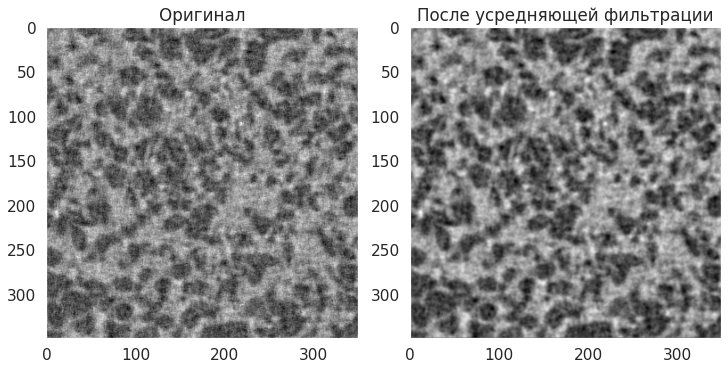

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)

axes[0].imshow(img2d, cmap='gray')
axes[0].set_title("Оригинал")
axes[0].grid()

kernel = np.asarray([[1, 1, 1],
                     [1, 1, 1],
                     [1, 1, 1]]) / 9
img2d_filt = signal.fftconvolve(img2d, kernel, mode='same')
axes[1].imshow(img2d_filt, cmap='gray')
axes[1].set_title("После усредняющей фильтрации")
axes[1].grid()


Я помню, что пористость этого образца 0.5, бинаризовывать и пересчитывать еще раз мне лень ;)

То есть вполне справедливо пользоваться формулой y=1.5\*x или, иначе говоря, <характическая ширина>=1.5*<характеристическая длина фантома>

Text(0.5, 1.0, 'Случайный ряд вокселей')

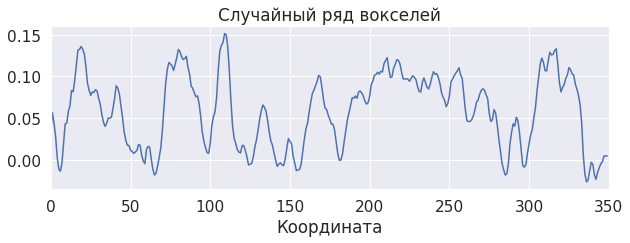

In [31]:
fig, ax = plt.subplots(figsize=(10,3))

real_sig = img2d_filt[200]
ax.plot(real_sig)
ax.set_xlim(0, real_sig.size)
ax.set_xlabel("Координата")
ax.set_title("Случайный ряд вокселей")



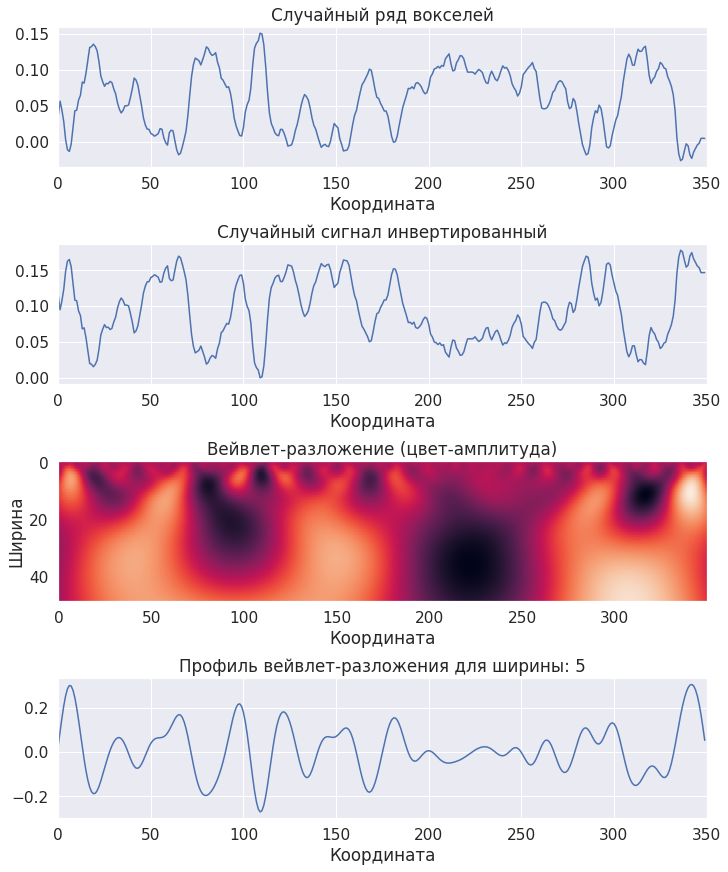

In [35]:
widths = np.arange(1, 50)
cwtmatr = signal.cwt(real_sig, signal.ricker, widths)

fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(10,3*4), constrained_layout=True)

axes[0].plot(real_sig)
axes[0].set_xlim(0, real_sig.size)
axes[0].set_title("Случайный ряд вокселей")
axes[0].set_xlabel("Координата")

real_sig_inv = invert_signal(real_sig)
axes[1].plot(real_sig_inv)
axes[1].set_xlim(0, real_sig.size)
axes[1].set_title("Случайный сигнал инвертированный")
axes[1].set_xlabel("Координата")

widths = np.arange(1, 50)
cwtmatr = signal.cwt(real_sig_inv, wavelet_func, widths)
axes[2].imshow(cwtmatr, aspect='auto')
axes[2].set_title("Вейвлет-разложение (цвет-амплитуда)")
axes[2].set_ylabel("Ширина")
axes[2].set_xlabel("Координата")
axes[2].grid()

w = 5
axes[3].plot(cwtmatr[w])
axes[3].set_xlim(0, real_sig_inv.size)
axes[3].set_title(f"Профиль вейвлет-разложения для ширины: {w}")
axes[3].set_xlabel("Координата")
None

Text(0.5, 0, 'Координата')

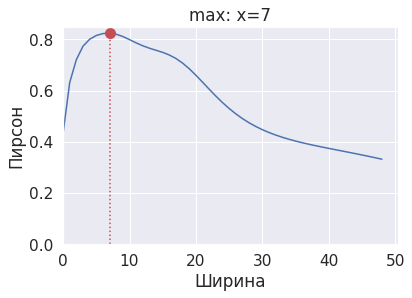

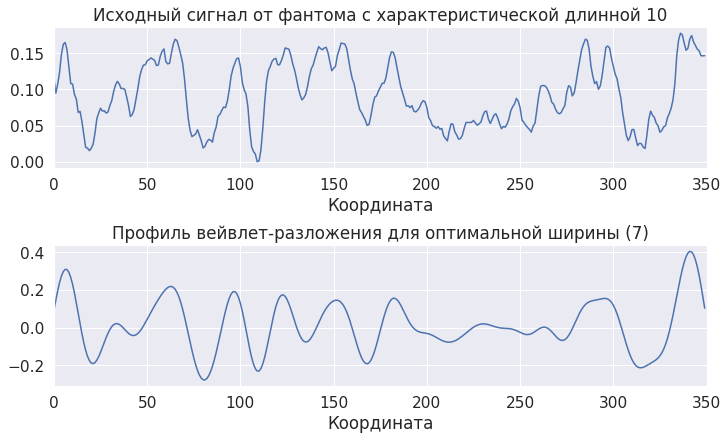

In [36]:
fig, ax = plt.subplots(figsize=(6,4))

pearsons = [stats.pearsonr(row, real_sig_inv)[0] for row in cwtmatr]
ax.plot(pearsons)
ax.plot([np.argmax(pearsons)], np.max(pearsons), '-o', c='r', markersize=10)
ax.axvline(np.argmax(pearsons), linestyle="dotted", color='r')
ax.set_title(f"max: x={np.argmax(pearsons)}")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_xlabel("Ширина")
ax.set_ylabel("Пирсон")

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,3*2), constrained_layout=True)

axes[0].plot(real_sig_inv)
axes[0].set_xlim(0, real_sig_inv.size)
axes[0].set_title(f"Исходный сигнал от фантома с характеристической длинной {characteristical_pore_length}")
axes[0].set_xlabel("Координата")

axes[1].plot(cwtmatr[np.argmax(pearsons)])
axes[1].set_xlim(0, real_sig_inv.size)
axes[1].set_title(f"Профиль вейвлет-разложения для оптимальной ширины ({np.argmax(pearsons)})")
axes[1].set_xlabel("Координата")

По формуле <характическая ширина>=1.5*<характеристическая длина фантома> полученной "на глаз" в рассуждениях выше, можно получить, что <характеристическая длина фантома> для нашего реального образца примерно равна 7/1.5 = 4.7

Text(0.5, 1.0, 'Фантом')

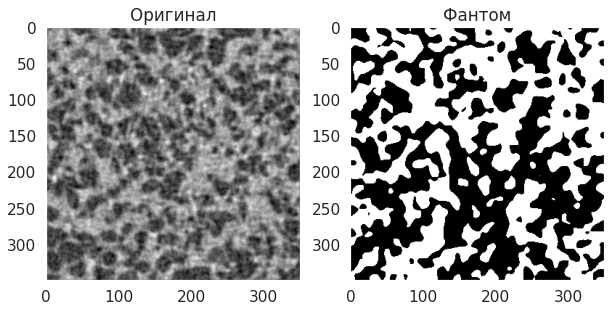

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(2*5,5))
axes[0].imshow(img2d_filt, cmap='gray')
axes[0].grid()
axes[0].set_title("Оригинал")

axes[1].imshow(pg.gen_phantom(img2d_filt.shape, 0.5, 4.7), cmap='gray')
axes[1].grid()
axes[1].set_title("Фантом")

Ну более менее похоже получилось.